In [1]:
#export
from dataclasses import dataclass
from functools import reduce, partial
import torch
from torch import optim
from nbs.dl2.exp.nb_02 import getMnistData, assertNearZero
from nbs.dl2.exp.nb_03 import Dataset, createDataLoaders, accuracy
from nbs.dl2.exp.nb_04 import DataBunch
from nbs.dl2.exp.nb_05 import aggregateSchedulers, createCosineSchedulers, cosineScheduler
from nbs.dl2.exp.nb_06 import normalizeVectors, createBetterConvolutionModel
from nbs.dl2.exp.nb_07D import *

In [2]:
%matplotlib inline


In [3]:
xTraining, yTraining, xValidation, yValidation = getMnistData()
xTrainingNormalized, xValidationNormalized = \
    normalizeVectors(xTraining, xValidation)

In [4]:
assertNearZero(xTrainingNormalized.mean())
assertNearZero(xValidationNormalized.mean())
assertNearZero(1 - xTrainingNormalized.std())
assertNearZero(1 - xValidationNormalized.std())


In [5]:
layerSizes = [8, 16, 32, 64, 64]
numberOfClasses = 10
hiddenLayerSize = 75
batchSize = 64

In [6]:
trainingDataSet, validationDataSet = Dataset(xTrainingNormalized[:10000], yTraining[:10000]), Dataset(xValidationNormalized[:10000], yValidation[:10000])
trainingDataLoader, validationDataLoader = createDataLoaders(trainingDataSet, validationDataSet, batchSize)
imageDataBunch = DataBunch(trainingDataLoader, validationDataLoader, numberOfClasses)

In [8]:
class ProcessCancellationException(Exception): pass

In [9]:
def composeFunctions(funInput, functions): 
    return reduce(lambda accum, function: function(accum), 
                  functions, 
                  funInput)

In [10]:
result = composeFunctions(0, [
    lambda x: x + 1,
    lambda x: x + 2,
    lambda x: x + 3,
])

assert result == 6, "Composition is wrong"

In [11]:
@dataclass
class HyperParameters:
    learningRate: float

In [12]:
#export
def flatMap(function, items):
    return reduce(lambda accum, manyItems: accum + manyItems,
           list(map(function, items)))

In [13]:
result = flatMap(lambda n: list(map(lambda _: n+1, range(n+1))), 
        list(range(3)))

assert result == [1, 2, 2, 3, 3, 3], "Flat map did not work"


In [14]:
class OptimizationFunction:
    
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        return hyperParameters
    
class LearningRateAnnealer(OptimizationFunction):
    def __init__(self, learningRateSupplier)-> None:
        self._learningRateSupplier = learningRateSupplier
        
    def __call__(self, modelLayer, hyperParameters: HyperParameters):
        hyperParameters.learningRate = self._learningRateSupplier()
        return super().__call__(modelLayer, hyperParameters)
    
class LearningRateOptimizer(OptimizationFunction):
    def __call__(self, 
                 modelLayer, 
                 hyperParameters: HyperParameters):
        modelLayer.data.add_(-hyperParameters.learningRate, modelLayer.grad.data)
        return super().__call__(modelLayer, hyperParameters)

In [15]:
class Optimizer:
    def __init__(self, modelParameters, 
                 optimizationFunctions,
                 hyperParameters: HyperParameters=HyperParameters(0.5)):
        super().__init__()
        self._modelParameters = list(modelParameters)
        self._hyperParameters = [hyperParameters for _ in self._modelParameters]
        self._optimizationFunctions = optimizationFunctions
        
    def getLayersWithGradients(self):
        return list(filter(lambda modelAndHyperParameters: modelAndHyperParameters[0].grad is not None, 
                           zip(self._modelParameters, self._hyperParameters)))
    
    def resetGradients(self):
        for modelParameter, _ in self.getLayersWithGradients():
            modelParameter.grad.detach_()
            modelParameter.grad.zero_()
    
    def optimizeModel(self):
        for modelParameter, hyperParameter in self.getLayersWithGradients():
            composeFunctions(hyperParameter, 
                             map(lambda fun: partial(fun, modelParameter), 
                                 self._optimizationFunctions))

In [16]:
convolutionalModelSR2 = createBetterConvolutionModel(numberOfClasses, layerSizes)

In [17]:
optimus = Optimizer(convolutionalModelSR2.parameters(), [])
len(optimus.getLayersWithGradients())

0

In [18]:
loss = torch.nn.functional.cross_entropy(convolutionalModelSR2(xTrainingNormalized), yTraining)
loss.backward()
len(optimus.getLayersWithGradients())

12

In [48]:
class LearningRateRecorder:
    def __init__(self, 
                 learningRateSupplier=lambda:0.5):
        super().__init__()
        self._aggregatedLearningRates = []
        self._learningRateSupplier = learningRateSupplier
    def __call__(self):
        learningRateReturned = self._learningRateSupplier()
        self._aggregatedLearningRates.append(learningRateReturned)
        return learningRateReturned
    
    def plotLearningRates(self):
        plotter.plot(self._aggregatedLearningRates)

## **Important Note**: PyTorch will NOT put the gradients on the parameters until backwards has been called on the model    

In [49]:
# todo: learning rate recording
class TrainingSubscriber(StatisticsSubscriber, 
                         HookedSubscriber):

    def __init__(self,
                 lossFunction=torch.nn.functional.cross_entropy,
                 schedulingFunction=cosineScheduler(1e-1, 1e-6), 
                 optimizationFunctions=[]
                 ):
        super().__init__(name="Training")
        self._optimizer: Optimizer = None
        self._optimizationFunctions = optimizationFunctions
        self._schedulingFunction = schedulingFunction
        self._lossFunction = lossFunction
        
        self._learningRateRecorder = LearningRateRecorder()
        
        
        
    def plotLearningRate(self):
        self._learningRateRecorder.plotLearningRates()
        
    def getOptimizationFunctions(self):
        self._learningRateRecorder = LearningRateRecorder(lambda: self._schedulingFunction(self._currentEpoch / self._totalEpochs) )
        return [
            LearningRateAnnealer(self._learningRateRecorder),
            LearningRateOptimizer()  
        ]

    def preModelTeach(self, model, epochs):
        super().preModelTeach(model, epochs)
        self._optimizer = Optimizer(model.parameters(), 
                                    self.getOptimizationFunctions(),
                                    HyperParameters(
                                        learningRate=self._schedulingFunction(0)
                                    ))
        self._totalEpochs = epochs

    def postBatchEvaluation(self, predictions, validationData):
        super().postBatchEvaluation(predictions, validationData)
        calculatedLoss = self._lossFunction(predictions, validationData)
        self._teachModel(calculatedLoss)
        self.postBatchLossConsumption(calculatedLoss)

    def _teachModel(self, loss):
        loss.backward() # adds auto gradients to model parameters
        self._optimizer.optimizeModel()
        self._optimizer.resetGradients() 

In [50]:
class TeacherOptimized:
    def __init__(self,
                 dataBunch,
                 trainingSubscriber: TrainingSubscriber,
                 validationSubscriber: ValidationSubscriber):
        self._dataBunch = dataBunch
        self._trainingSubscriber = trainingSubscriber
        self._validationSubscriber = validationSubscriber

    def teachModel(self, model, numberOfEpochs):
        self._notifiyPreTeach(model, numberOfEpochs)
        for epoch in range(numberOfEpochs):
            self._trainModel(model,
                             epoch)
            self._validateModel(model,
                                epoch)
        self._notifiyPostTaught()

    def _notifiyPreTeach(self, model, epochs):
        self._trainingSubscriber.preModelTeach(model, epochs)
        self._validationSubscriber.preModelTeach(model, epochs)

    def _notifiyPostTaught(self):
        self._trainingSubscriber.postModelTeach()
        self._validationSubscriber.postModelTeach()

    def _trainModel(self, model, epoch):
        self._processData(model,
                          self._dataBunch.trainingDataSet,
                          epoch,
                          self._trainingSubscriber)

    def _validateModel(self, model, epoch):
        with torch.no_grad():
            self._processData(model,
                              self._dataBunch.validationDataSet,
                              epoch,
                              self._validationSubscriber)

    def _processData(self,
                     model,
                     dataLoader,
                     epoch,
                     processingSubscriber: Subscriber):
        processingSubscriber.preEpoch(epoch, dataLoader)
        try:
            for _xDataBatch, _yDataBatch in dataLoader:
                processingSubscriber.preBatchEvaluation()
                _predictions = model(_xDataBatch)
                processingSubscriber.postBatchEvaluation(_predictions, _yDataBatch)
        except ProcessCancellationException: pass
        finally:
            processingSubscriber.postEpoch(epoch)


In [63]:
#export
def createCosineScheduler(start, high, end):
    return [cosineScheduler(start, high), cosineScheduler(high, end)]

def createWeightAndBiasSchedulers():
    phases = [0.3, 0.7]
    _weightsScheduler = aggregateSchedulers(phases, createCosineScheduler(0.3, 0.6, 0.2)) 
    _biasScheduler = aggregateSchedulers(phases, createCosineScheduler(0.9, 1.8, 0.6))
    return _weightsScheduler, _biasScheduler

In [64]:
validationSubscriber = ValidationSubscriber()

In [65]:
weightScheduler, biasScheduler = createWeightAndBiasSchedulers()

trainingSubscriber = TrainingSubscriber(schedulingFunction=weightScheduler)

In [66]:
teacher = TeacherEnhanced(imageDataBunch, 
                          trainingSubscriber,
                          validationSubscriber
                         )


In [67]:
convolutionalModelSR1 = createBetterConvolutionModel(numberOfClasses, layerSizes)


In [68]:
accuracy(convolutionalModelSR1(validationDataSet.xVector), validationDataSet.yVector)

tensor(0.1009)

In [69]:
teacher.teachModel(convolutionalModelSR1, 3)

Epoch #0 Training: Loss 1.6901013851165771 Accuracy 0.36713773012161255
Epoch #0 Validation: Loss 0.0 Accuracy 0.8657041192054749
Epoch #1 Training: Loss 0.3980051577091217 Accuracy 0.8794785141944885
Epoch #1 Validation: Loss 0.0 Accuracy 0.9266218543052673
Epoch #2 Training: Loss 0.11377991735935211 Accuracy 0.9655652642250061
Epoch #2 Validation: Loss 0.0 Accuracy 0.9659810066223145


In [70]:
accuracy(convolutionalModelSR1(validationDataSet.xVector), validationDataSet.yVector)

tensor(0.9656)

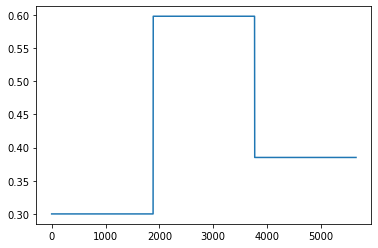

In [72]:
trainingSubscriber.plotLearningRate()

## Things to look at later

- Learning Rate Capping
- Bias Learning rate annealing


